# 04. Explainability with Grad-CAM

This notebook implements Gradient-weighted Class Activation Mapping (Grad-CAM) to visualize model focus.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Config
IMG_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
CLASSES = ['hemorrhagic', 'ischemic', 'tumor']

DATA_ROOT = '../Data'
DATA_SOURCES = {
    'hemorrhagic': [
        os.path.join(DATA_ROOT, 'Brain_Stroke_CT_Dataset', 'Bleeding', 'PNG')
    ],
    'ischemic': [
        os.path.join(DATA_ROOT, 'Brain_Stroke_CT_Dataset', 'Ischemia', 'PNG')
    ],
    'tumor': [
        os.path.join(DATA_ROOT, 'archive (1)', 'Training', 'glioma'),
        os.path.join(DATA_ROOT, 'archive (1)', 'Training', 'meningioma'),
        os.path.join(DATA_ROOT, 'archive (1)', 'Training', 'pituitary')
    ]
}

Using device: mps


## 1. Grad-CAM Implementation
Using PyTorch hooks to extract gradients and activations.

In [5]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)
        
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)
            
        score = output[:, class_idx].squeeze()
        score.backward()
        
        # Global Average Pooling of gradients
        gradients = self.gradients[0]
        activations = self.activations[0]
        
        weights = torch.mean(gradients, dim=(1, 2))
        weights = weights.view(-1, 1, 1)
        
        # Weighted combination of activations
        cam = torch.sum(weights * activations, dim=0)
        cam = F.relu(cam)
        
        cam = cam.detach().cpu().numpy()
        # Normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        return cam

## 2. Load Model and Apply

Loaded best_cnn.pth
Processing image: ../Data/Brain_Stroke_CT_Dataset/Bleeding/PNG/12781.png


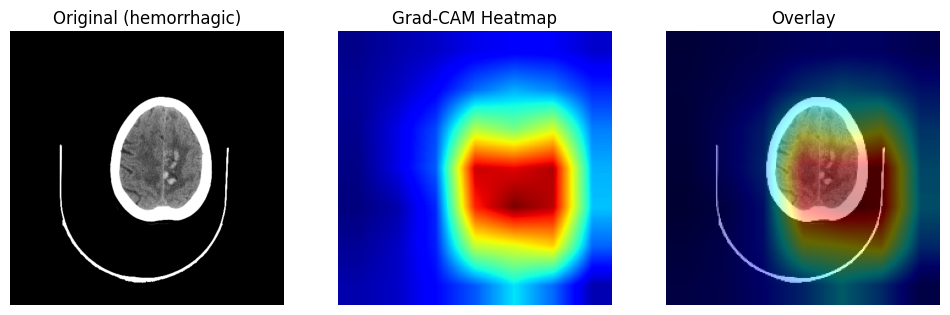

In [11]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Re-instantiate model structure
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(CLASSES))
try:
    model.load_state_dict(torch.load('../models/best_cnn.pth', map_location=DEVICE))
    print("Loaded best_cnn.pth")
except:
    print("Model weights not found. Please run notebook 02 first.")
    
model = model.to(DEVICE)
model.eval()

# Attach Grad-CAM to the last convolutional layer (layer4)
grad_cam = GradCAM(model, model.layer4)

# Load a real image from dataset
import random
target_class = 'hemorrhagic'
source_dirs = DATA_SOURCES[target_class]
valid_images = []
for d in source_dirs:
    if os.path.exists(d):
        valid_images.extend([os.path.join(d, f) for f in os.listdir(d) if f.lower().endswith(('.png', '.jpg'))])

if valid_images:
    img_path = random.choice(valid_images)
    print(f"Processing image: {img_path}")
    
    try:
        img_pil = Image.open(img_path).convert('RGB')
        img_tensor = get_transforms()(img_pil).unsqueeze(0).to(DEVICE)

        # Run Grad-CAM
        heatmap = grad_cam(img_tensor)
        
        # Visualize
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(img_pil)
        plt.title(f'Original ({target_class})')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title('Grad-CAM Heatmap')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        # Overlay
        img_np = np.array(img_pil) / 255.0
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
        
        overlay = heatmap_colored * 0.4 + cv2.resize(img_np, (224, 224)) * 0.6
        plt.imshow(overlay)
        plt.title('Overlay')
        plt.axis('off')
        
        plt.show()
    except Exception as e:
        print(f"Error processing image: {e}")
else:
    print("No images found for testing.")